# Use HuggingFace model in the VILA-M3 workflow

## Download the models and VLM

In [ ]:
# Download the pretrained model
from huggingface_hub import snapshot_download

local_dir = snapshot_download(
    repo_id="MONAI/VISTA3D-HF",
    local_dir=".",
)


m3_model_dir = snapshot_download(
    repo_id="MONAI/Llama3-VILA-M3-8B",
    local_dir="./vila_m3_8b",
)


## Download and cache images

In [1]:
import os
from agent_utils import ImageCache

LIVER_URL = "https://developer.download.nvidia.com/assets/Clara/monai/samples/ct_liver_0.nii.gz"

cache_dir = "../data"
cache_images = ImageCache(cache_dir)

os.makedirs(cache_dir, exist_ok=True)
cache_images.cache({"Sample 1": LIVER_URL})

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 75/75 [00:00<00:00, 87844.96it/s]


## Define the expert VISTA-3D model using the HuggingFace pipeline

In [2]:
import os
from pathlib import Path
from shutil import move
from uuid import uuid4
import tempfile
import re
import requests
from agent_utils import get_monai_transforms, get_slice_filenames, SEGMENTATION_TOKEN, VISTA_LABEL_DICT
from hugging_face_pipeline import HuggingFacePipelineHelper
import torch


class ExpertVista3DHF():
    """Expert model for VISTA-3D."""

    def __init__(self) -> None:
        """Initialize the VISTA-3D expert model."""
        self.model_name = "VISTA3D"
        self.label_groups = VISTA_LABEL_DICT
        self.pipeline = HuggingFacePipelineHelper("vista3d").init_pipeline(
            "vista3d_pretrained_model",
            device=torch.device("cuda:0"),
        )

    def label_id_to_name(self, label_id: int, label_dict: dict):
        """
        Get the label name from the label ID.

        Args:
            label_id: the label ID.
            label_dict: the label dictionary.
        """
        for group_dict in list(label_dict.values()):
            if isinstance(group_dict, dict):
                # this will skip str type value, such as "everything": <path>
                for label_name, label_id_ in group_dict.items():
                    if label_id == label_id_:
                        return label_name
        return None

    def segmentation_to_string(
        self,
        output_dir: Path,
        img_file: str,
        seg_file: str,
        label_groups: dict,
        modality: str = "CT",
        slice_index: int | None = None,
        axis: int = 2,
        image_filename: str = "image.jpg",
        label_filename: str = "label.jpg",
        output_prefix=None,
    ):
        """
        Format the segmentation response to a string.

        Args:
            response: the response.
            output_dir: the output directory.
            img_file: the image file path.
            modality: the modality.
            slice_index: the slice index.
            axis: the axis.
            image_filename: the image filename for the sliced image.
            label_filename: the label filename for the sliced image.
            group_label_names: the group label names to filter the label names.
            output_prefix: the output prefix.
        """
        global SEGMENTATION_TOKEN
        output_dir = Path(output_dir)
        if output_prefix is None:
            output_prefix = f"The results are {SEGMENTATION_TOKEN}. The colors in this image describe "

        transforms = get_monai_transforms(
            ["image", "label"],
            output_dir,
            modality=modality,
            slice_index=slice_index,
            axis=axis,
            image_filename=image_filename,
            label_filename=label_filename,
        )
        data = transforms({"image": img_file, "label": seg_file})

        formatted_items = []

        for label_id in data["colormap"]:
            label_name = self.label_id_to_name(label_id, label_groups)
            if label_name is not None:
                color = data["colormap"][label_id]
                formatted_items.append(f"{color}: {label_name}")

        return output_prefix + ", ".join(formatted_items) + ". "

    def mentioned_by(self, input: str):
        """
        Check if the VISTA-3D model is mentioned in the input.

        Args:
            input (str): Text from the LLM, e.g. "Let me trigger <VISTA3D(arg)>."

        Returns:
            bool: True if the VISTA-3D model is mentioned, False otherwise.
        """
        matches = re.findall(r"<(.*?)>", str(input))
        if len(matches) != 1:
            return False
        return self.model_name in str(matches[0])

    def download_file(self, url: str, img_file: str):
        """
        Download the file from the URL.

        Args:
            url (str): The URL.
            img_file (str): The file path.
        """
        parent_dir = os.path.dirname(img_file)
        os.makedirs(parent_dir, exist_ok=True)
        with open(img_file, "wb") as f:
            response = requests.get(url)
            f.write(response.content)

    def run(
        self,
        img_file: str = "",
        image_url: str = "",
        input: str = "",
        output_dir: str = "",
        slice_index: int = 0,
        prompt: str = "",
        **kwargs,
    ):
        """
        Run the VISTA-3D model.

        Args:
            image_url (str): The image URL.
            input (str): The input text.
            output_dir (str): The output directory.
            img_file (str): The image file path. If not provided, download from the URL.
            slice_index (int): The slice index.
            prompt (str): The prompt text from the original request.
            **kwargs: Additional keyword arguments.
        """
        if not img_file:
            # Download from the URL
            img_file = os.path.join(output_dir, os.path.basename(image_url))
            self.download_file(image_url, img_file)

        output_dir = Path(output_dir)
        matches = re.findall(r"<(.*?)>", input)
        if len(matches) != 1:
            raise ValueError(f"Expert model {self.model_name} is not correctly enclosed in angle brackets.")

        match = matches[0]

        # Extract the arguments
        arg_matches = re.findall(r"\((.*?)\)", match[len(self.model_name) :])

        if len(arg_matches) == 0:  # <VISTA3D>
            arg_matches = ["everything"]
        if len(arg_matches) == 1 and (arg_matches[0] == "" or arg_matches[0] == None):  # <VISTA3D()>
            arg_matches = ["everything"]
        if len(arg_matches) > 1:
            raise ValueError(
                "Multiple expert model arguments are provided in the same prompt, "
                "which is not supported in this version."
            )

        vista3d_prompts = None

        if arg_matches[0] not in self.label_groups:
            raise ValueError(f"Label group {arg_matches[0]} is not accepted by the VISTA-3D model.")

        if arg_matches[0] != "everything":
            vista3d_prompts = [cls_idx for _, cls_idx in self.label_groups[arg_matches[0]].items()]

        # Trigger the VISTA-3D model
        input_dict = {"image": img_file}
        if vista3d_prompts is not None:
            input_dict["label_prompt"] = vista3d_prompts
        else:
            input_dict["label_prompt"] = [int(i) for i in range(1, 16)]

        with tempfile.TemporaryDirectory() as temp_dir:
            self.pipeline([input_dict], output_dir=temp_dir)
            seg_file = os.path.join(output_dir, "segmentation.nii.gz")
            temp_output_dir = os.path.join(temp_dir, os.listdir(temp_dir)[0])
            output_file = os.path.join(temp_output_dir, os.listdir(temp_output_dir)[0])
            if os.path.exists(seg_file):
                if os.path.isdir(seg_file):
                    from shutil import rmtree
                    rmtree(seg_file)
                else:
                    os.remove(seg_file)
            move(output_file, seg_file)
            print(f"File exists: {os.path.exists(seg_file)}")

        seg_image = f"seg_{uuid4()}.jpg"
        text_output = self.segmentation_to_string(
            output_dir,
            img_file,
            seg_file,
            self.label_groups,
            modality="CT",
            slice_index=slice_index,
            image_filename=get_slice_filenames(img_file, slice_index),
            label_filename=seg_image,
        )

        if "segmented" in input:
            instruction = ""  # no need to ask for instruction
        else:
            instruction = "Use this result to respond to this prompt:\n" + prompt
        return text_output, os.path.join(output_dir, seg_image), instruction



## (Optional) Test the expert VISTA-3D model

In [3]:
expert = ExpertVista3DHF()
with tempfile.TemporaryDirectory() as temp_dir:
    text_output, seg_image, instruction = expert.run(
        img_file=cache_images.get(LIVER_URL),
        input="Let me trigger <VISTA3D(everything)>.",
        prompt="Describe the image.",
        output_dir="../data",
        slice_index=0,
    )
    print("="*50 + "test run:" + "="*50)
    print(f"Image segmentation is saved to {seg_image}")
    print(f"Instruction passed to the follow-up prompt:\n{instruction}")
    print(f"Text output:\n{text_output}")
    print("="*100)

2025-03-06 09:30:31,773 INFO image_writer.py:197 - writing: /tmp/tmpvnif8y3q/ct_liver_0/ct_liver_0_seg.nii.gz
File exists: True
==================================================test run:==================================================
Image segmentation is saved to ../data/seg_c5ca585f-4469-4979-9dc4-a23594830e23.jpg
Instruction passed to the follow-up prompt:
Use this result to respond to this prompt:
Describe the image.
Text output:
The results are <segmentation>. The colors in this image describe red: liver, blue: spleen, yellow: pancreas, magenta: right kidney, green: aorta, indigo: inferior vena cava, darkorange: right adrenal gland, cyan: left adrenal gland, pink: gallbladder, brown: esophagus, orange: stomach, lime: left kidney, orange: bladder. 


## Use the expert VISTA-3D model in the VILA-M3 workflow

In [4]:
from agent_utils import SessionVariables, ChatHistory, M3Generator

model_path = "./vila_m3_8b"
sv = SessionVariables()
m3 = M3Generator(
        cache_images,
        source="local",
        model_path=model_path,
        conv_mode="llama_3",
        experts_classes=[ExpertVista3DHF],
    )

sv.image_url = LIVER_URL
sv.slice_index = 57

chat_history = ChatHistory()

sv, chat_history = m3.process_prompt(
    "Is there a hepatic tumor in the image",
    sv,
    chat_history
)

print("="*100)

[2025-03-06 09:30:38,850] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-03-06 09:30:38 - root - INFO - x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmptwatawzl/test.c -o /tmp/tmptwatawzl/test.o
2025-03-06 09:30:38 - root - INFO - x86_64-linux-gnu-gcc /tmp/tmptwatawzl/test.o -laio -o /tmp/tmptwatawzl/a.out
/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
2025-03-06 09:30:39 - root - INFO - x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmp1jpm4nrw/test.c -o /tmp/tmp1jpm4nrw/test.o
2025-03-06 09:30:39 - root - INFO - x86_64-linux-gnu-gcc /tmp/tmp1jpm4nrw/test.o -L/usr/local/cuda -L/usr/local/cuda/lib64 -lcufile -o /tmp/tmp1jpm4nrw/a.out
2025-03-06 09:30:39 - root - INFO - x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wa

2025-03-06 09:30:53,223 INFO image_writer.py:197 - writing: /tmp/tmppc0aqo95/ct_liver_0/ct_liver_0_seg.nii.gz
File exists: True


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


USER:
Here is a list of available expert models:
<BRATS(args)> Modality: MRI, Task: segmentation, Overview: A pre-trained model for volumetric (3D) segmentation of brain tumor subregions from multimodal MRIs based on BraTS 2018 data, Accuracy: Tumor core (TC): 0.8559 - Whole tumor (WT): 0.9026 - Enhancing tumor (ET): 0.7905 - Average: 0.8518, Valid args are: None
<VISTA3D(args)> Modality: CT, Task: segmentation, Overview: domain-specialized interactive foundation model developed for segmenting and annotating human anatomies with precision, Accuracy: 127 organs: 0.792 Dice on average, Valid args are: 'everything', 'hepatic tumor', 'pancreatic tumor', 'lung tumor', 'bone lesion', 'organs', 'cardiovascular', 'gastrointestinal', 'skeleton', or 'muscles'
<VISTA2D(args)> Modality: cell imaging, Task: segmentation, Overview: model for cell segmentation, which was trained on a variety of cell imaging outputs, including brightfield, phase-contrast, fluorescence, confocal, or electron microscopy

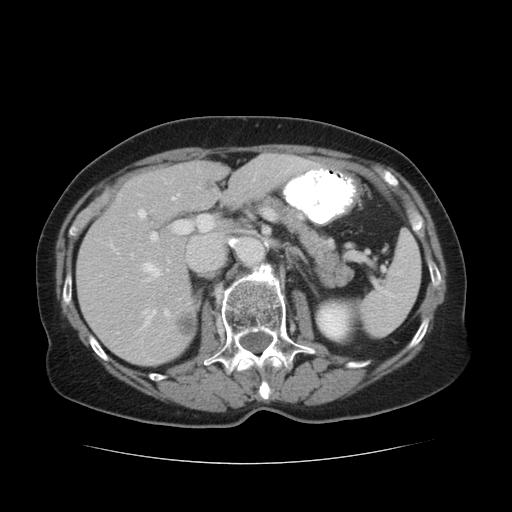

ASSISTANT:
This looks like a CT image. Let me trigger <VISTA3D(hepatic tumor)>.
EXPERT:
The results are <segmentation>. The colors in this image describe red: liver. 
Using image: /tmp/tmpaqibmlfn/seg_b4bb3706-b9eb-4b17-99fc-be617eec9c02.jpg


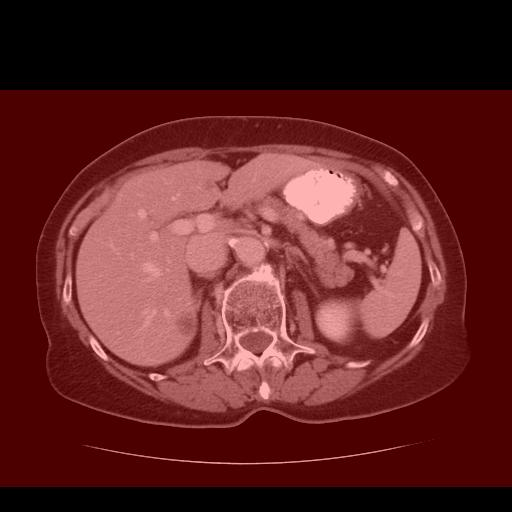

EXPERT:
Use this result to respond to this prompt:
Is there a hepatic tumor in the image
ASSISTANT:
no.


In [5]:
from colored import fg, attr
from PIL import Image

# Define colors for different roles
ROLE_COLORS = {
    "USER": fg("green"),
    "ASSISTANT": fg("blue"),
    "EXPERT": fg("yellow")
}

for message in chat_history.messages:
    role = message["role"].upper()
    content = message["content"]
    # Get color for role, default to white if role not in dictionary
    color = ROLE_COLORS.get(role, fg("white"))
    # Print role with color and reset color afterwards
    print(f"{color}{role}:{attr('reset')}")
    for item in content:
        if item['type'] == 'text':
            print(item['text'])
        elif item['type'] == 'image_path':
            print(f"Using image: {item['image_path']}")
            image = Image.open(item['image_path'])
            image.show()
        else:
            continue